#  MelodyMaster
## Notebook02 - Metrics & kNN
### Idan Kashani & Or Raphael Bidusa

# Welcome Back!
Today we shall build our first classifier, using the already preprocessed data from part 1.
Make sure to run part 1 in order to get the right csv files, you can run `01 - script.py` instead of the notebook itself.

In [75]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
np.random.seed(42)

First, we will load the dataset and split it to training set and validation set.

In [76]:
df = pd.read_csv('../train.csv')
lyrics = df['lyrics']
artists = df['artist']
all_but_artists = df[['lyrics','song_name','url','words count','unique words count']]

X_train, X_val, y_train, y_val = train_test_split(all_but_artists, artists, test_size=0.15, stratify=artists, random_state=42)

# Save to CSV
train_df = pd.DataFrame(np.c_[ X_train,y_train], columns = ['lyrics','song_name','url','words count','unique words count','artist'])
val_df = pd.DataFrame(np.c_[ X_val,y_val], columns = ['lyrics','song_name','url','words count','unique words count','artist'])
print(f'train shape: {train_df.shape}, validation shape: {val_df.shape}')

train shape: (7221, 6), validation shape: (1275, 6)


## Vocabulary is Key
Each song in our dataset will be represented and embedded in three different ways, Bag-of-Words, Set-of-Words and TF-IDF.
In order to create these representations we need to work with a *vocabulary* - a set of all the words in the training set.

In [77]:
train_df['lyrics_as_list'] = train_df['lyrics'].map(lambda l: set(ast.literal_eval(str(l))))
vocabulary = list(sorted(set.union(*train_df['lyrics_as_list'].tolist())))
print(vocabulary)
print(f"Vocabulary length is: {len(vocabulary)}")

["'א", "'אבל'", "'אוי", "'אין'", "'אנחנו", "'אני", "'בואי", "'בואי'", "'בוואלה'", "'בטיח", "'בעד", "'בעד'", "'בראבו'", "'ה", "'הגדולה'", "'הוא", "'זה", "'חד", "'חריסולה'", "'חת", "'טוב", "'טיליגנטי", "'ילדי", "'ך", "'כוכבים", "'כי", "'כם", "'כן'", "'כנס", "'לא", "'לבלות'", "'לימלך", "'מונאמי'", "'מי", "'מים", "'משקאות", "'נגד'", "'ני", "'נתגבר", "'סה", "'סחתן'", "'סתובבתי", "'סתכל", "'סתכלי", "'סתכלים", "'עגלה", "'עוד", "'ענני", "'פירסט", "'צ'זבטי'", "'צ'יזבט'", "'קבורה'", "'רכבה'", "'רע'", "'שבעה'", "'שחק", "'שלום", "'שמפיין'", "'שק", "'תגיד", "'תה", "'תושיה'", "'תי", "'תיישבתי", "'תלב", "'תם", '16אף', 'Blצder', 'FLOW', 'Fuckin', 'JDים', 'Libertא', 'frבher', 'wהr', "א'", "א'פחד", 'אƔ', 'אאאהה', 'אאבד', 'אאבדך', 'אאבק', 'אאדיר', 'אאהאאה', 'אאההה', 'אאוט', 'אאונץ', 'אאזין', 'אאזינה', 'אאחר', 'אאיר', 'אאכזב', 'אאלבי', 'אאמין', 'אאמינה', 'אאסוף', 'אארוג', 'אארוז', 'אאתר', 'אב', "אב'אלה", "אב'שך", 'אבא', "אבא'לה", 'אבאדי', 'אבאים', "אבאל'ה", 'אבאלה', 'אבאס', 'אבגוד', 'אבד', 'אבדאללה', 'אבד

## Bag-of-Words Representation
The first representation of a sample in the dataset will be the Bag-of-Words representation (BoW).
In BoW, each song is represented by a vector in the size of the vocabulary.
The i-th entry in the vector contains the number of times the corresponding i-th word in the vocabulary appeared in the song.
For example, if the following lines were a complete song:

`טוליק, הי טוליק, תן לי עינב`
`אך טוליק שותק, כמעט נעלב`

They would be represented by a vector from the size of 56940 (the size of the vocabulary).
The entry which represents the word `טוליק` would have the value of 3 and all the other words with the value of 1.

As you can infer, the vectors are going to be sparse, and therefore we will use <class 'scipy.sparse._csr.csr_matrix'> for storing them.
This class will help us with doing arithmetic operations efficiently, using the fact that the vectors are sparse.


In [78]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_bow = CountVectorizer(vocabulary=vocabulary)
BoW_train = vectorizer_bow.fit_transform(train_df.lyrics)
print(f"The size of the vocabulary is indeed: {len(vectorizer_bow.get_feature_names_out())}")

The size of the vocabulary is indeed: 56940


Let's look upon the song `טוליק` by the artist `אושיק לוי`.
By manually counting, the word `טוליק` appears 8 times, the word `יושב` appears 4 times and the word `רינה` only once.

In [79]:
def word_count(v,w):
    print(f"The word {w} appears {v[0,vocabulary.index(w)]} times")

tulik_bow = BoW_train[train_df.index[train_df['song_name'] == "טוליק"].tolist()[0]]
word_count(tulik_bow,'טוליק')
word_count(tulik_bow,'יושב')
word_count(tulik_bow,'רינה')

The word טוליק appears 8 times
The word יושב appears 4 times
The word רינה appears 1 times


## Set-of-Words Representation
A bit less complicated representations is the Set-of-Words (SoW).
Instead of a counter for each word in the vocabulary there's an index - whether the word appears in the song or not regardless of quantity.
Although less informative, according to [Jurafsky and Martin](http://web.stanford.edu/~jurafsky/slp3/), somtimes SoW representation does better with classification than BoW does.
We will try both of the embeddings and determine which one is better using the validation set.


In [81]:
vectorizer_sow = CountVectorizer(vocabulary=vocabulary, binary=True)
SoW_train = vectorizer_sow.fit_transform(train_df.lyrics)
tulik_sow = SoW_train[train_df.index[train_df['song_name'] == "טוליק"].tolist()[0]]
word_count(tulik_sow,'טוליק')
word_count(tulik_sow,'יושב')
word_count(tulik_sow,'רינה')

The word טוליק appears 1 times
The word יושב appears 1 times
The word רינה appears 1 times


## tf-idf Representation

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(vocabulary=vocabulary)
tfidf_train = vectorizer_tfidf.fit_transform(train_df.lyrics)

## cloud - BoW


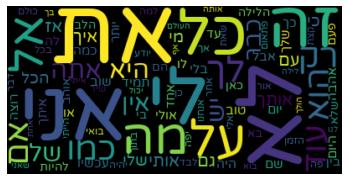

In [205]:
from wordcloud import wordcloud
import math
bow_sum = tfidf_train.mean(axis=0) #BoW_train.sum(axis=0)
#print(vocabulary[bow_sum.argmax()])
bow_inx = np.argsort(bow_sum).tolist()[0][-100:]
#print([vocabulary[l] for l in bow_inx])
bow_text= ""
for w in bow_inx:
    bow_text += (vocabulary[w][::-1]+" w ") * math.ceil(100000*bow_sum[0,w])
#print(bow_text)


import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(font_path='../hebrewFont.ttf',stopwords=['w']).generate(bow_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [206]:
train_df[train_df['artist']=="עופר לוי"].song_name

29       נסתרות דרכי האל
39                 הקלפן
240          אתן לך עולם
387         לכי נא נערתי
529     החזירי לי את בני
              ...       
6745          ממלכת העיר
6809               צודקת
6822            אני חוזר
6886        המשיכי לחייך
7102              אני עף
Name: song_name, Length: 62, dtype: object